In [1]:
import skimage.measure
from matplotlib import pyplot as plt
from rich import cells
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling
from napari_segment_blobs_and_things_with_membranes import seeded_watershed
from napari_segment_blobs_and_things_with_membranes import local_minima_seeded_watershed

from skimage.filters import gaussian
from pyclesperanto_prototype import imshow

In [2]:
#load tif

image = imread('/home/jadeaphillips/Quantitative_Bio_Image_Analysis_with_Python_2022-main/data/rnascope/MAX_5 zoom.tif')

image.shape

(336, 366, 3)

(np.float64(-0.5), np.float64(365.5), np.float64(335.5), np.float64(-0.5))

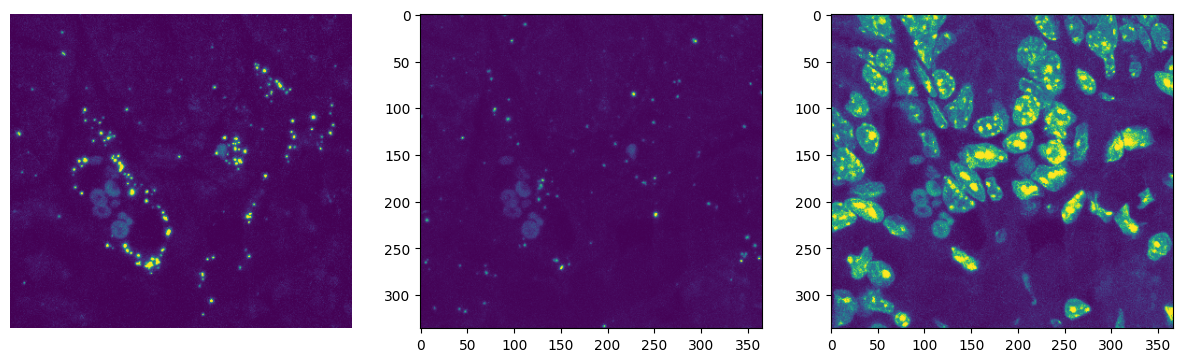

In [3]:
#split the channels

piezo1=image[:,:,0]
dapi=image[:,:,1]
pecam1=image[:,:,2]

#plot each channel

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
(axes[0].imshow(pecam1))
axes[0].axis('off')

(axes[1].imshow(piezo1))
axes[0].axis('off')

(axes[2].imshow(dapi))
axes[0].axis('off')

(np.float64(-0.5), np.float64(365.5), np.float64(335.5), np.float64(-0.5))

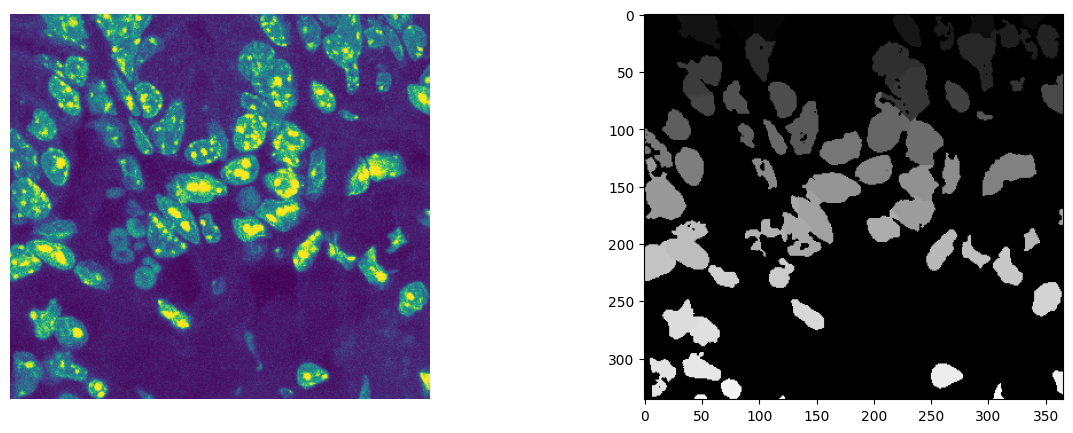

In [4]:
#segment the nuclei and plot

labeled_nuclei=voronoi_otsu_labeling(dapi, spot_sigma=6, outline_sigma=1)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
(axes[0].imshow(dapi))
axes[0].axis('off')

(axes[1].imshow(labeled_nuclei, cmap='grey'))
axes[0].axis('off')

(np.float64(-0.5), np.float64(365.5), np.float64(335.5), np.float64(-0.5))

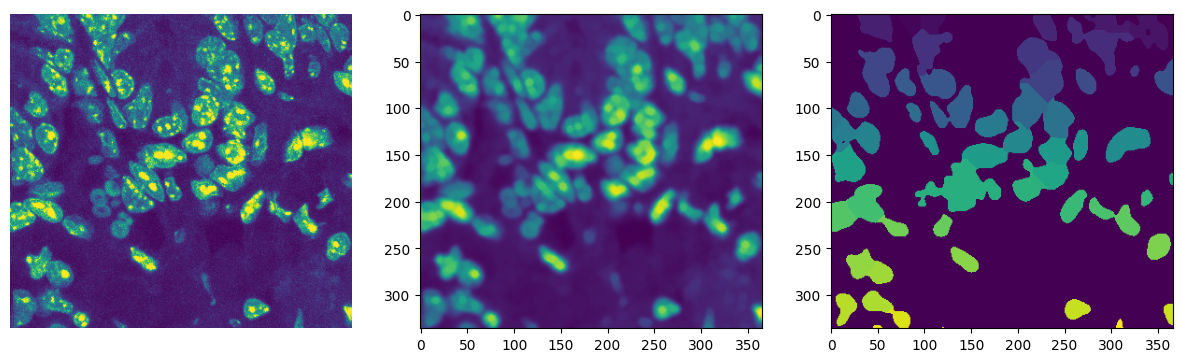

In [5]:
#missing alot of nuclei so preprocess

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import gaussian
from skimage.morphology import white_tophat, disk
from skimage.filters import threshold_local


# Pre-processing
blurred_dapi = gaussian(dapi, sigma=2)

# Background subtraction using a rolling ball algorithm (white top-hat)
background = white_tophat(blurred_dapi, disk(3))
subtracted_dapi = blurred_dapi - background

# Adaptive Thresholding
threshold_value = threshold_local(subtracted_dapi, block_size=101, method='gaussian')


# Now  use this binary mask for your labeling
labeled_nuclei = voronoi_otsu_labeling(blurred_dapi, spot_sigma=7, outline_sigma=2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
(axes[0].imshow(dapi))
axes[0].axis('off')

(axes[1].imshow(subtracted_dapi))
axes[0].axis('off')

(axes[2].imshow(labeled_nuclei))
axes[0].axis('off')



In [6]:

from scipy.spatial import Voronoi, voronoi_plot_2d
from skimage.segmentation import find_boundaries
from skimage.measure import regionprops_table

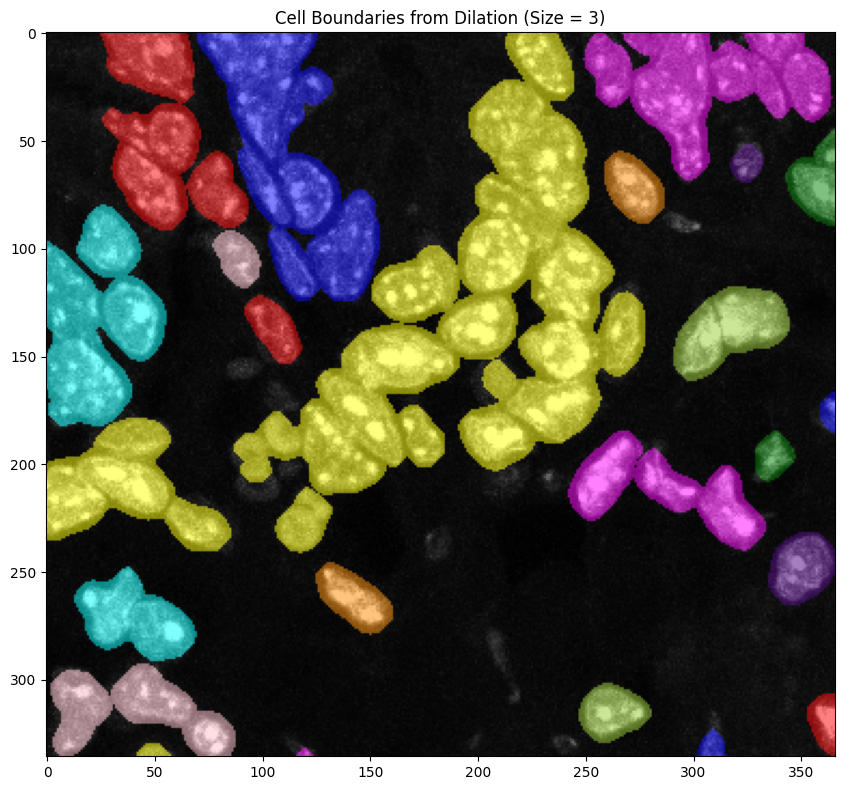

(np.float64(-0.5), np.float64(365.5), np.float64(335.5), np.float64(-0.5))

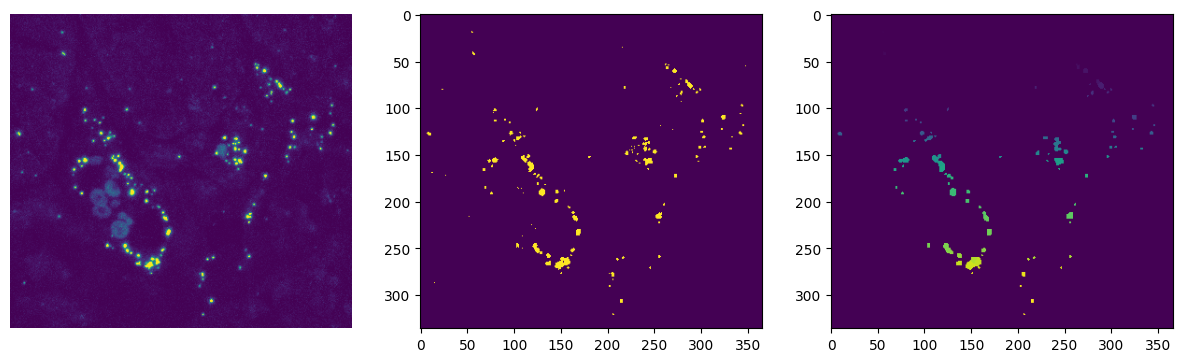

In [53]:
#make pecam1 into binary
threshold_value = 25000 # A placeholder; adjust as needed.

# Create a boolean (binary) mask.
binary_mask = pecam1 > threshold_value

# Convert the boolean mask to an integer array (0s and 1s or 0s and 255s)
# Multiplying by 255 makes the white pixels bright and easier to visualize.
binary_image = binary_mask.astype(np.uint8) * 255

labeled_pecam=voronoi_otsu_labeling(binary_image, spot_sigma=1, outline_sigma=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
(axes[0].imshow(pecam1))
axes[0].axis('off')

(axes[1].imshow(binary_image))
axes[0].axis('off')

(axes[2].imshow(labeled_pecam))
axes[0].axis('off')



(np.float64(-0.5), np.float64(365.5), np.float64(335.5), np.float64(-0.5))

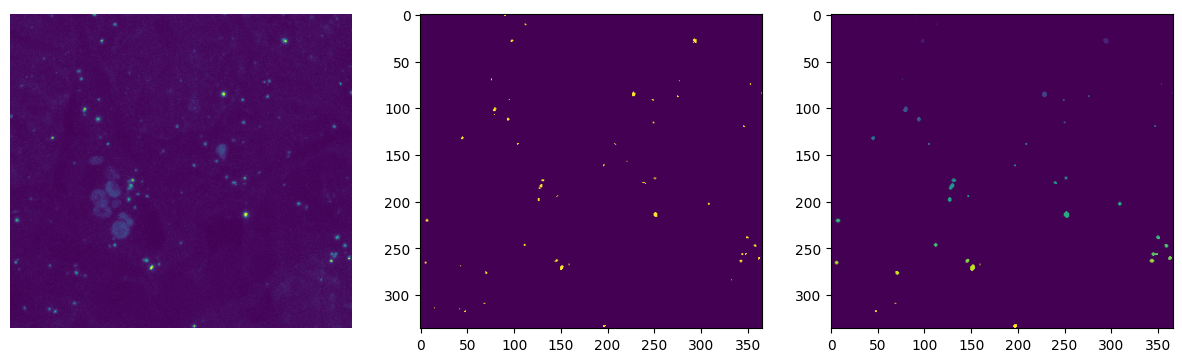

In [69]:
#make piezo1 into binary
threshold_value = 25000 # A placeholder; adjust as needed.

# Create a boolean (binary) mask.
binary_mask_piezo = piezo1 > threshold_value

# Convert the boolean mask to an integer array (0s and 1s or 0s and 255s)
# Multiplying by 255 makes the white pixels bright and easier to visualize.
binary_image_piezo = binary_mask_piezo.astype(np.uint8) * 255

labeled_piezo=voronoi_otsu_labeling(binary_image_piezo, spot_sigma=1, outline_sigma=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
(axes[0].imshow(piezo1))
axes[0].axis('off')

(axes[1].imshow(binary_image_piezo))
axes[0].axis('off')

(axes[2].imshow(labeled_piezo))
axes[0].axis('off')

(np.float64(-0.5), np.float64(365.5), np.float64(335.5), np.float64(-0.5))

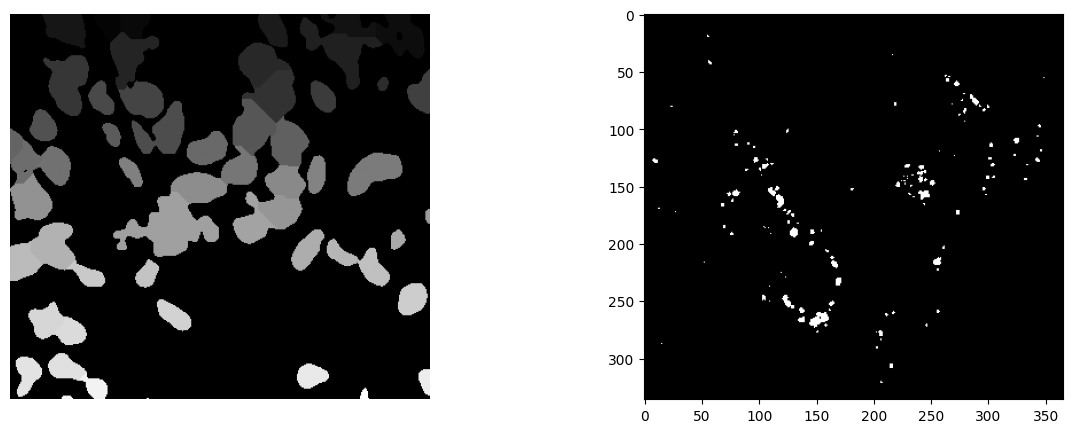

In [39]:


#labeled_cells = seeded_watershed(cell_boundaries, labeled_nuclei)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
(axes[0].imshow(labeled_nuclei, cmap = 'grey'))
axes[0].axis('off')

(axes[1].imshow(binary_image, cmap = 'grey'))
axes[0].axis('off')

In [62]:
from skimage.measure import label, regionprops

label_img_nuc = label(labeled_nuclei)
nuc_props = regionprops(label_img_nuc)
cell_count = label_img_nuc.max()

print(cell_count)

label_img_pec = label(labeled_pecam)
pecam_props = regionprops(label_img_pec)
pecam_count = label_img_pec.max()

print(pecam_count)


56
97


In [65]:
# Sum fluorescence in GFP channel within each labeled nucleus
# Label nuclei
import pandas as pd
#count amount of pecam per cell

label_img_nuc = label(labeled_nuclei)
nuc_props = regionprops(label_img_nuc)
cell_count = label_img_nuc.max()
print("Number of cells:", cell_count)

# Label PECAM dots
label_img_pec = label(labeled_pecam)
pecam_props = regionprops(label_img_pec)
pecam_count = label_img_pec.max()
print("Number of PECAM dots:", pecam_count)

# Map PECAM dots to cells
pecam_per_cell = {i: 0 for i in range(1, cell_count + 1)}

for pec in pecam_props:
    # Get centroid of each PECAM dot
    y, x = np.round(pec.centroid).astype(int)

    # Check which nucleus label this PECAM dot falls into
    cell_label = label_img_nuc[y, x]

    if cell_label > 0:  # means it's inside a cell
        pecam_per_cell[cell_label] += 1

# Print results
for cell_id, count in pecam_per_cell.items():
    print(f"Cell {cell_id}: {count} PECAM dots")

df = pd.DataFrame(list(pecam_per_cell.items()), columns=["Cell_ID", "PECAM_Count"])

# Save to CSV
df.to_csv("pecam_per_cell.csv", index=False)



Number of cells: 56
Number of PECAM dots: 97
Cell 1: 1 PECAM dots
Cell 2: 0 PECAM dots
Cell 3: 0 PECAM dots
Cell 4: 0 PECAM dots
Cell 5: 0 PECAM dots
Cell 6: 0 PECAM dots
Cell 7: 0 PECAM dots
Cell 8: 0 PECAM dots
Cell 9: 0 PECAM dots
Cell 10: 1 PECAM dots
Cell 11: 0 PECAM dots
Cell 12: 1 PECAM dots
Cell 13: 0 PECAM dots
Cell 14: 0 PECAM dots
Cell 15: 0 PECAM dots
Cell 16: 3 PECAM dots
Cell 17: 0 PECAM dots
Cell 18: 1 PECAM dots
Cell 19: 0 PECAM dots
Cell 20: 0 PECAM dots
Cell 21: 1 PECAM dots
Cell 22: 0 PECAM dots
Cell 23: 0 PECAM dots
Cell 24: 1 PECAM dots
Cell 25: 0 PECAM dots
Cell 26: 0 PECAM dots
Cell 27: 5 PECAM dots
Cell 28: 0 PECAM dots
Cell 29: 3 PECAM dots
Cell 30: 9 PECAM dots
Cell 31: 1 PECAM dots
Cell 32: 0 PECAM dots
Cell 33: 6 PECAM dots
Cell 34: 0 PECAM dots
Cell 35: 1 PECAM dots
Cell 36: 0 PECAM dots
Cell 37: 0 PECAM dots
Cell 38: 3 PECAM dots
Cell 39: 0 PECAM dots
Cell 40: 0 PECAM dots
Cell 41: 0 PECAM dots
Cell 42: 0 PECAM dots
Cell 43: 0 PECAM dots
Cell 44: 0 PECAM d

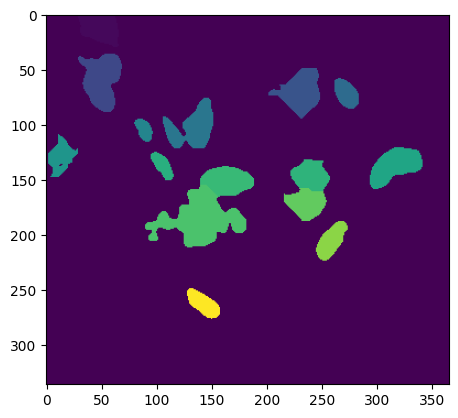

In [68]:
#now remove cells with a zero value for pecam so we are left with only endothelial cells

cells_with_pecam = [cell_id for cell_id, count in pecam_per_cell.items() if count > 0]

filtered_label_img_nuc = np.zeros_like(label_img_nuc)

for cell_id in cells_with_pecam:
    filtered_label_img_nuc[label_img_nuc == cell_id] = cell_id

plt.imshow(filtered_label_img_nuc)

In [74]:
#now measure piezo1 expression in filtered cells


#count amount of pecam per cell

label_img_nuc = label(filtered_label_img_nuc)
nuc_props = regionprops(label_img_nuc)
cell_count = label_img_nuc.max()
print("Number of cells:", cell_count)

# Label PECAM dots
label_img_pec = label(labeled_piezo)
pecam_props = regionprops(label_img_pec)
pecam_count = label_img_pec.max()
print("Number of PECAM dots:", pecam_count)

# Map PECAM dots to cells
pecam_per_cell = {i: 0 for i in range(1, cell_count + 1)}

for pec in pecam_props:
    # Get centroid of each PECAM dot
    y, x = np.round(pec.centroid).astype(int)

    # Check which nucleus label this PECAM dot falls into
    cell_label = label_img_nuc[y, x]

    if cell_label > 0:  # means it's inside a cell
        pecam_per_cell[cell_label] += 1

# Print results
for cell_id, count in pecam_per_cell.items():
    print(f"Cell {cell_id}: {count} Piezo dots")

df = pd.DataFrame(list(pecam_per_cell.items()), columns=["Cell_ID", "Piezo_Count"])

# Save to CSV
df.to_csv("piezo_per_cell.csv", index=False)










Number of cells: 15
Number of PECAM dots: 42
Cell 1: 0 Piezo dots
Cell 2: 0 Piezo dots
Cell 3: 1 Piezo dots
Cell 4: 0 Piezo dots
Cell 5: 0 Piezo dots
Cell 6: 1 Piezo dots
Cell 7: 0 Piezo dots
Cell 8: 0 Piezo dots
Cell 9: 1 Piezo dots
Cell 10: 0 Piezo dots
Cell 11: 0 Piezo dots
Cell 12: 4 Piezo dots
Cell 13: 2 Piezo dots
Cell 14: 1 Piezo dots
Cell 15: 2 Piezo dots
